# Imports

In [75]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import src
from src import *
import importlib
importlib.reload(src)
import lexnlp as lnlp
%matplotlib inline

# Reading in categorical data

In [76]:
df2 = pd.read_csv("../data/SCDB_2020_01_caseCentered_Citation.csv",encoding='cp1252' )# importing csv

In [109]:
df2 = df2[df2.partyWinning != 2]
df2 = df2[df2.majVotes < 7]

In [78]:
plt.style.use(['fivethirtyeight']) #making my graphs look purd..ier
plt.style.use(['seaborn-poster'])

# Data Visualization

## Decision Direction

In [79]:
df2.decisionDirection.value_counts()# checking on the variable decision direction

2.0    4534
1.0    4302
3.0     155
Name: decisionDirection, dtype: int64

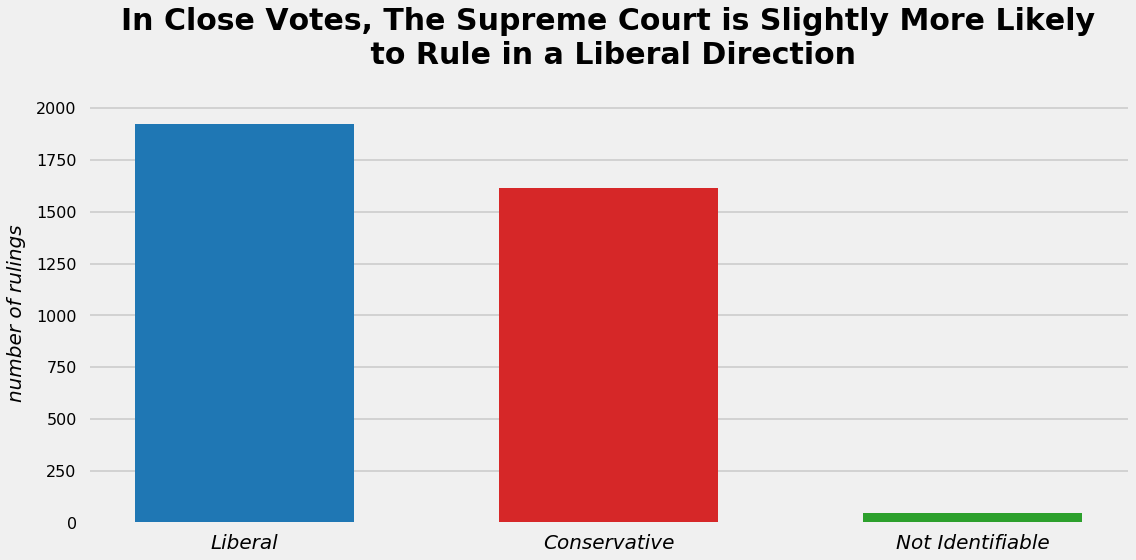

In [80]:
plt.figure(figsize = (16, 8))#figsize
colors = ('tab:blue', 'tab:red', 'tab:green')#custom color palletes 
# using the value counts queries and labels in an easier to manipulate(for me) list 
outcome = ['Liberal', 'Conservative', 'Not Identifiable']
count = [1926, 1614, 47]
plt.bar(outcome, count, color= colors, width =.6 )#plotting
plt.title('In Close Votes, The Supreme Court is Slightly More Likely\n to Rule in a Liberal Direction', 
          fontweight ='bold', size =30, pad = 40, loc = 'center')#title
#style tweaks
plt.ylabel("number of rulings", size = 20, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')
plt.tight_layout()
plt.savefig("../images/outcome_direction.png", bbox_inches='tight')

Since 1946 in close cases *(6 or less votes in the majority)* the Supreme Court has been more likely to rule in a liberal direction, liberal, conservative and not identifiable are defined in the  2020 Supreme Court [codebook](http://scdb.wustl.edu/documentation.php?var=decisionDirection) where this data was obtained.

## Whether or not the petitioner won

In [81]:
#tabulating how many cases the petitioner won or lost 
df2.partyWinning.value_counts()/len(df2) #the target variables 

1.0    0.638427
0.0    0.359247
2.0    0.000554
Name: partyWinning, dtype: float64

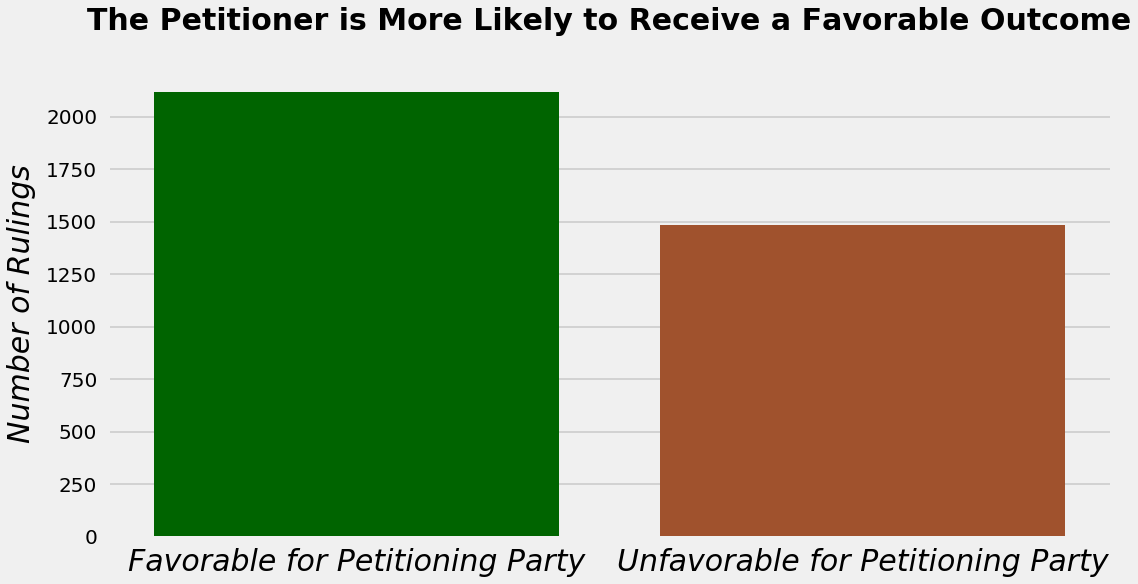

In [144]:
plt.figure(figsize = (16, 8)) #figure
outcome = ['Favorable for Petitioning Party', 'Unfavorable for Petitioning Party']#labels
count = [2116, 1486]#data
colors2 = ('darkgreen', 'sienna')#custom color pallete 
plt.bar(outcome, count, color = colors2 )#plot
plt.title('The Petitioner is More Likely to Receive a Favorable Outcome', 
          fontweight ='bold', size = 30, pad = 40, loc = 'center')# title
#style tweaks
plt.ylabel("Number of Rulings", size = 30, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 30)
plt.yticks(size = 20)
plt.grid(axis = 'x')
fig.tight_layout()
plt.savefig('../images/petitioner.png', bbox_inches='tight', transperent = True)

Since 1946 in close cases, the petitioner is more likely to recieve a favorable opinion. Note that this does not neccesarily mean they outright 'won' the case, this variable is further documented [here.](http://scdb.wustl.edu/documentation.php?var=partyWinning)This means that the Supreme Court is more likely to overturn lower court decisions than uphold them. Since my target variable is whether the the petitioning party wins this relationship represents a class imbalance in my data. 

# What was the Decision Direction when the Petitioner won or lost?

Decision direction is a variable that indicates what the "idealogy" of the ruling was. 

In [83]:
df2[df2['partyWinning'] == 0]['decisionDirection'].value_counts()# querying the decision direction when the petitoner won
#(partyWinning == 0) and what the decision direction was, 1 = liberal, 2 = conservative and 3 is unknown

1.0    1819
2.0    1318
3.0      85
Name: decisionDirection, dtype: int64

In [84]:
df2[df2['partyWinning'] == 1]['decisionDirection'].value_counts()# querying the decision direction when the petitoner lost
#(partyWinning == 1) and what the decision direction was, 1 = liberal, 2 = conservative and 3 is unknown

2.0    3216
1.0    2482
3.0      67
Name: decisionDirection, dtype: int64

In [132]:
countL = [894, 546, 30]
countW = [1068, 1032, 16]
sumL = 894+546+30
sumW = 1068 + 1032 +16
perL = [x/sumL for x in countL] #converting to percentages
perW = [x/sumW for x in countW] #converting to percentages
outcome = ['Liberal', 'Conservative', 'Not Identifiable']

x = np.arange(len(outcome))


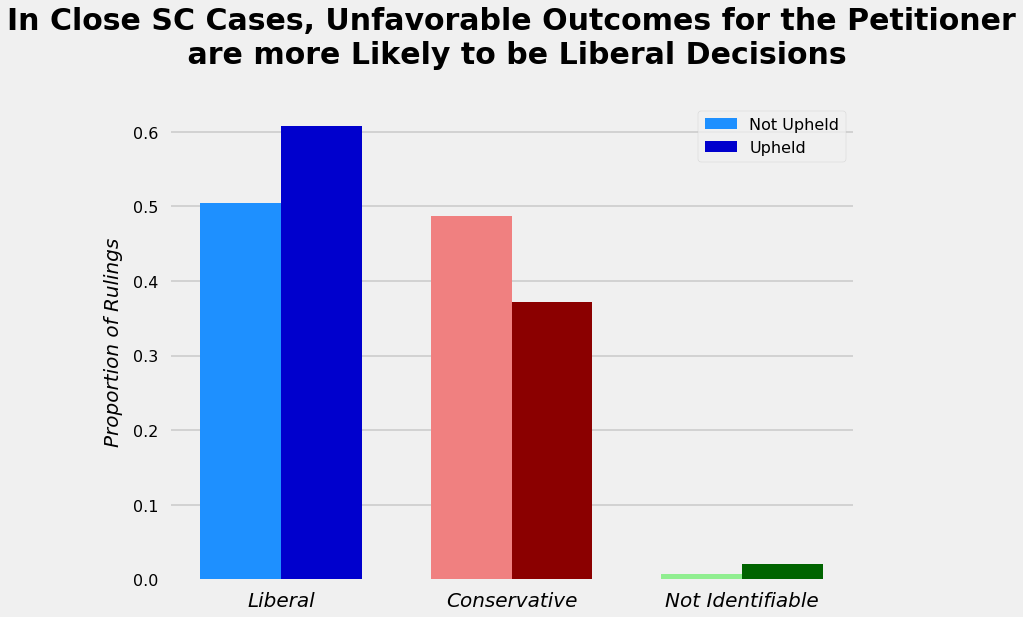

<Figure size 921.6x633.6 with 0 Axes>

In [139]:

labels = ['Liberal', 'Conservative', 'Not Identifiable']#labels

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
colorsw = ['dodgerblue','lightcoral', 'lightgreen'] # custom color palletes 
colorsl= ['mediumblue', 'darkred', 'darkgreen']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, perW, width, label='Not Upheld', color = colorsw)
rects2 = ax.bar(x + width/2, perL, width, label='Upheld', color = colorsl)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of Rulings', style = 'italic', labelpad = 10, size = 20)
ax.set_title('''In Close SC Cases, Unfavorable Outcomes for the Petitioner\n are more Likely to be Liberal Decisions''',
             fontweight ='bold', size = 30, pad = 40, loc = 'center')
ax.set_xticks(x)
ax.set_xticklabels(labels, style = 'italic', size = 20)
ax.legend()
plt.grid(axis = 'x')
fig.tight_layout()
plt.show()
plt.savefig('../images/scdisposition.png', bbox_inches='tight')

This graphic shows that the SC is about equally as likely to rule in liberal or conservative direction when ruling in favor of the petitioner but more likely to rule in a liberal direction when ruling in a manner not favorable for the petitioner. Essentially, the Court is more likely to uphold decisions by lower courts that were liberal. Unfortunately I cannot predict on that so lets see if this relationship holds for the decision direction of the lower court.

In [134]:
df2[df2['partyWinning'] == 0]['lcDispositionDirection'].value_counts()# querying the decision direction of the lower court
#when the petitoner won (partyWinning == 0) and what the decision direction was, 1 = liberal, 2 = conservative and 3 is unknown

1.0    879
2.0    543
3.0     35
Name: lcDispositionDirection, dtype: int64

In [135]:
df2[df2['partyWinning'] == 1]['lcDispositionDirection'].value_counts()# querying the decision direction of the lower court
#when the petitoner lost (partyWinning == 1) and what the decision direction was, 1 = liberal, 2 = conservative and 3 is unknown

1.0    1054
2.0    1026
3.0      10
Name: lcDispositionDirection, dtype: int64

In [136]:
countLl = [879, 543, 35]
countWl = [1054, 1026, 10]

perLl = [x/sum(countLl) for x in countLl] #converting to percentages
perWl = [x/sum(countWl) for x in countWl] #converting to percentages

I find it easier with a fairly small amount of variable to just write out my variables rather than try to graph the query directly and have weird things happen.

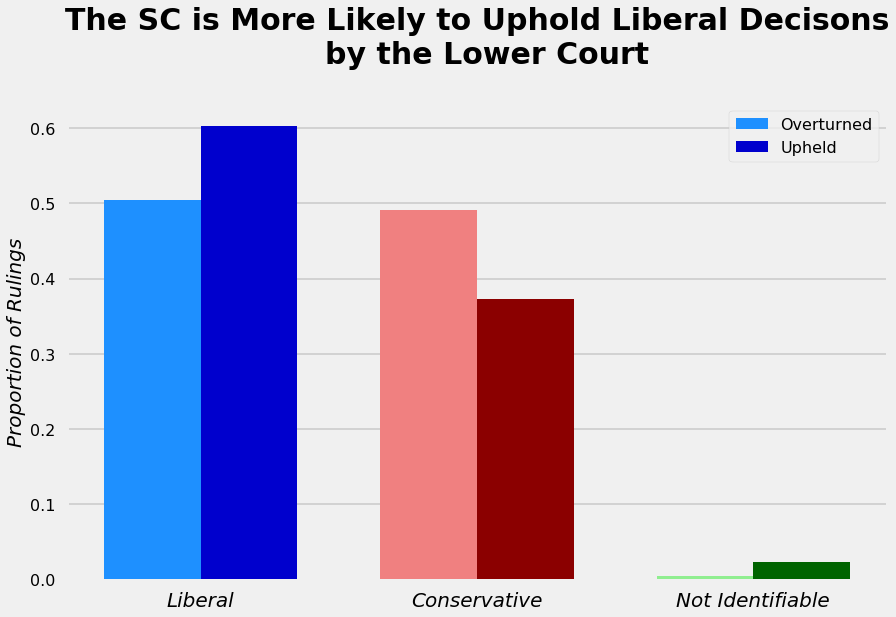

In [147]:
# eseentially the same code as the previous graph 
labels = ['Liberal', 'Conservative', 'Not Identifiable']
liberal = countWl
liberal = countLl
x = np.arange(len(labels))  
width = 0.35  
colorsw = ['dodgerblue','lightcoral', 'lightgreen']
colorsl= ['mediumblue', 'darkred', 'darkgreen']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, perWl, width, label='Overturned', color = colorsw)
rects2 = ax.bar(x + width/2, perLl, width, label='Upheld', color = colorsl)
ax.set_ylabel('Proportion of Rulings', style = 'italic',size = 20)
ax.set_title('''The SC is More Likely to Uphold Liberal Decisons\n  by the Lower Court''',
             fontweight ='bold', size = 30, pad = 40, loc = 'center')
ax.set_xticks(x)
ax.set_xticklabels(labels, style = 'italic', size = 20)
ax.legend()
plt.grid(axis = 'x')
fig.tight_layout()
plt.savefig('../images/lcdisposition.png', bbox_inches='tight')

This graphic further shows this relationship. When the Lower Court rules in a liberal direction it is less likely the petitioner will be succesful.

## What Issues are argued before the SC most often 

In [51]:
df2.issue.value_counts()#queryin the most common issues heard before the SC in close cases, the issues are coded 
#and can be found in the SCDB codebook

10050.0     132
10020.0     101
30010.0      99
80010.0      93
10130.0      75
120010.0     62
80060.0      61
10170.0      61
80100.0      55
10120.0      54
20400.0      53
80070.0      49
90120.0      48
80040.0      47
100030.0     44
10090.0      43
40070.0      42
30190.0      42
20110.0      41
80130.0      40
80050.0      39
10060.0      39
40010.0      36
20060.0      35
20090.0      35
90320.0      34
10270.0      34
20040.0      34
60010.0      34
80120.0      32
10010.0      30
20160.0      30
100020.0     29
10100.0      29
50020.0      29
20180.0      26
80020.0      26
10040.0      26
30060.0      26
80110.0      26
10080.0      25
90110.0      25
20020.0      24
70040.0      24
40040.0      23
40020.0      23
10160.0      23
80030.0      23
30150.0      22
90150.0      22
10560.0      21
90130.0      21
80180.0      21
70070.0      21
10370.0      21
10580.0      20
30180.0      20
20280.0      20
20070.0      19
30170.0      19
20130.0      19
30160.0      18
20150.0 

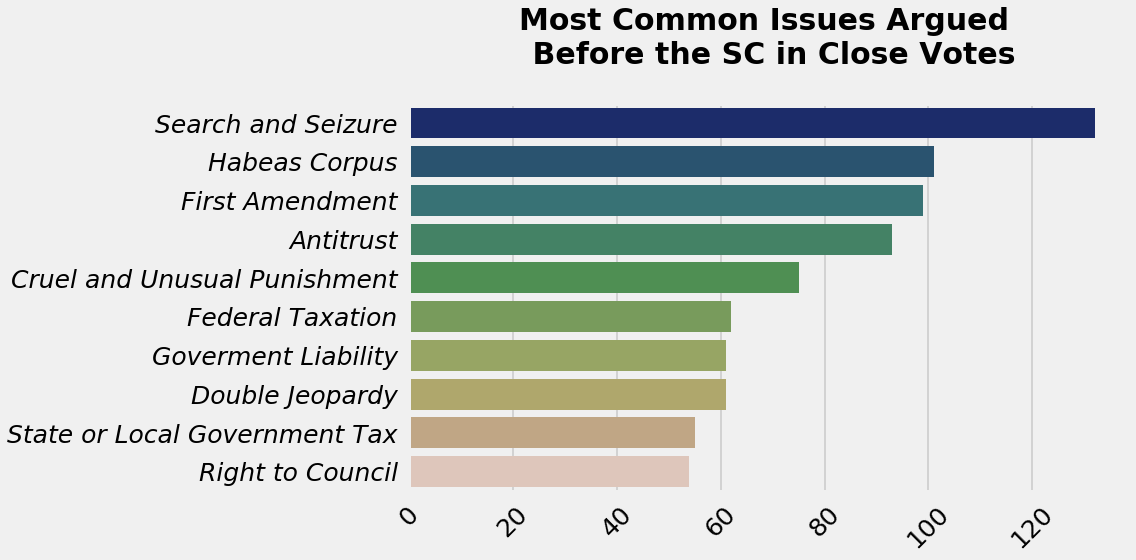

In [114]:

fig = plt.figure(figsize= (16, 8))#plot
ax = fig.add_subplot(111)
count = [132, 101, 99, 93, 75, 62, 61, 61, 55, 54] #the number of cases involving each issue
labels = ['Search and Seizure', 'Habeas Corpus','First Amendment' ,'Antitrust', 'Cruel and Unusual Punishment', 
          'Federal Taxation', 'Goverment Liability', 'Double Jeopardy', 
          'State or Local Government Tax', 'Right to Council']# the issue
dfg = pd.DataFrame(count, labels)# I wanted to try some things in seaborn so i quickly made a df
sns.barplot(count, labels, data = dfg, palette = 'gist_earth' )#barplot + color palette
ax.set_title('Most Common Issues Argued \n Before the SC in Close Votes', 
             size = 30, fontweight = 'bold',pad = 40, loc= 'center') #title
#formatting and further titles
plt.xticks(rotation = 45, size = 25)
plt.yticks(size = 25, fontstyle = 'italic')
fig.set_tight_layout(True)
plt.savefig("../images/common_issues.png", bbox_inches='tight')

These are the 10 issues that are argued before the SC in close cases, Search and Seizure is the most common by a large margin. 

## Most Common issue over Time

As a proxy for time, I wil use the Chief Justice when the case was argued. This will be more efficient to implement and the each tenure still represents distinct eras within the court.

In [135]:
Roberts = list(df2[df2.chief == 'Roberts']['issue'].value_counts())
Warren = list(df2[df2.chief == 'Warren']['issue'].value_counts())
Burger = list(df2[df2.chief == 'Burger']['issue'].value_counts())
Rehnquist = list(df2[df2.chief == 'Rehnquist']['issue'].value_counts())

#querying the most common issues when Chief Justice Roberts, the current
#CJ was the CJ, I will use who the CJ was as a proxy for time and to define the different eras of the court, 
#this is common practice in legal study



In [137]:
# I made the same query for every other justice, then added a list of the issues which I just manually 
#looked up in the SCDB.
# I like to make lists of all my variables as I find it easier to trouble shoot graph style issues
warren = [10050, 80010, 80040] #codes
countwarren = [38, 35, 32] #number
perWar = [x/len(df2[df2.chief == 'Warren']) * 100 for x in countwarren]#converting to percentages
dfWar = pd.DataFrame(perWar, countwarren)#was expirementing with some Seaborn stuff again
labelsWarren = ["Search and Seizure", "Government Tax", "Suffiency of Evidence"]#labels for the codes
burger = [10050, 30010, 80010] #codes
countburger = [45, 38, 29]#number
perburg = [x/len(df2[df2.chief == 'Burger']) * 100 for x in countburger]#converting to percentages
labelsBurger =  ['Search and Seizure', 'First Amendment', 'Government Tax' ]#labels for the codes
rehnquist = [10020, 10130, 30010]#codes
countrehn = [43, 32, 27]#number
perrehn = [x/len(df2[df2.chief == 'Rehnquist'] ) * 100 for x in countrehn]#converting to percentages
labelsRehnquist = ['Habeas Corpus', 'Cruel and Unusual Punishment', 'Government Tax']#labels for the codes
Roberts = [10020, 10130, 10050]#codes
countroberts = [23, 17, 16]#number
perrob = [x/len(df2[df2.chief == 'Roberts']) * 100for x in countroberts]#converting to percentages
labelsRoberts = ['Habeas Corpus', 'Cruel and Unusual Punishment', 'Search and Seizure']#labels for the codes

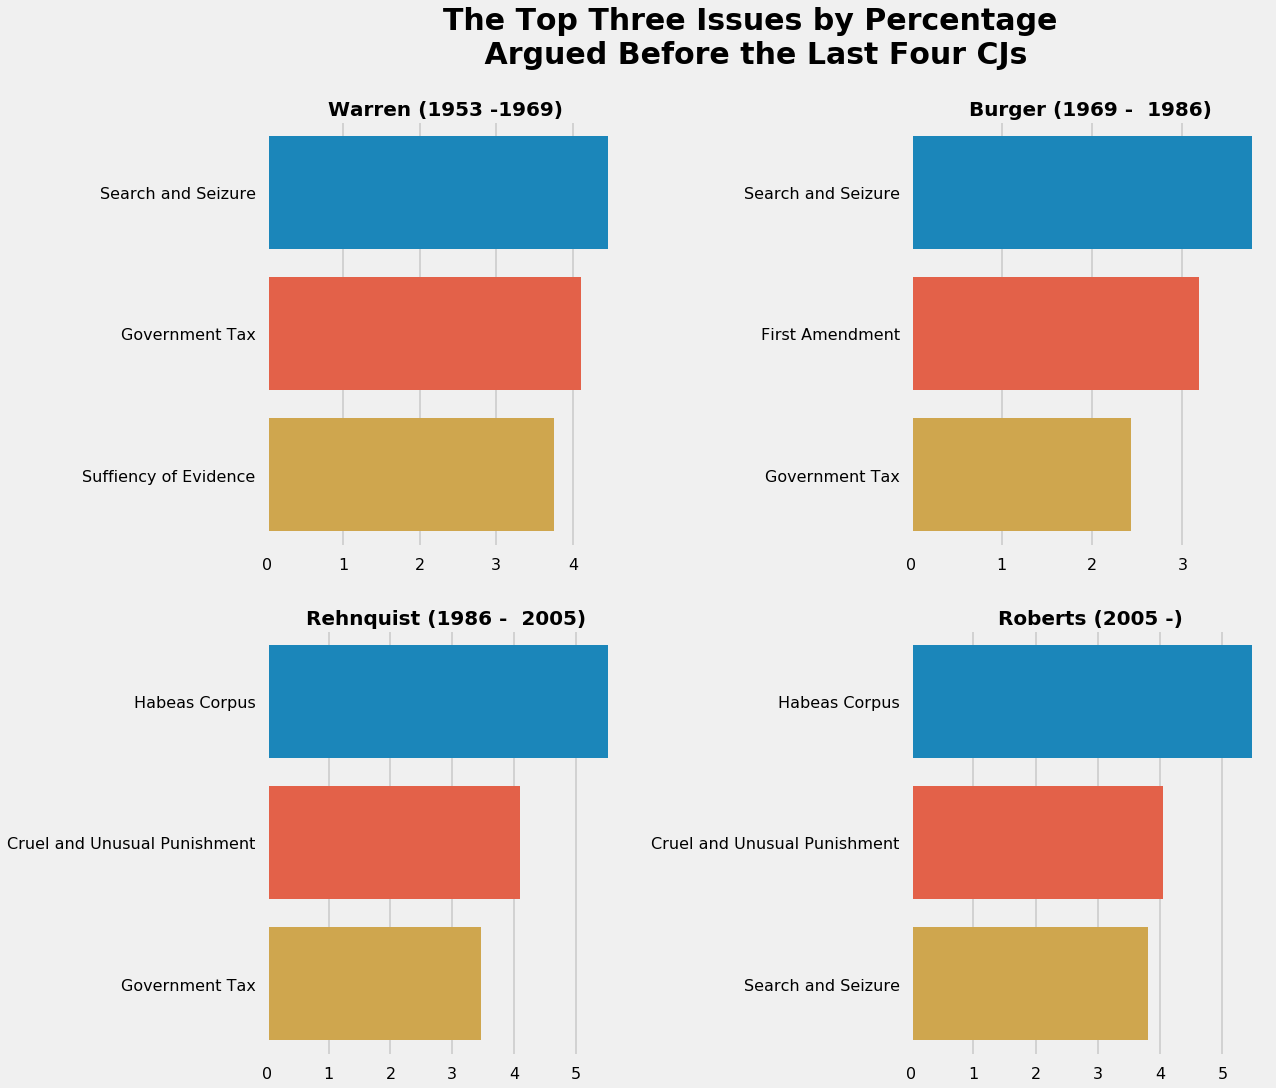

In [129]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 16)) #generating figure and axes
#overall title
fig.suptitle("The Top Three Issues by Percentage\n Argued Before the Last Four CJs", size = 30, fontweight = 'bold')
#graphing each individual plot
sns.barplot( perWar, labelsWarren, data = dfWar, ax = axarr[0, 0])
axarr[0,0].set_title("Warren (1953 -1969)", size = 20, fontweight = 'bold')
sns.barplot(perburg, labelsBurger, ax = axarr[0,1])
axarr[0,1].set_title("Burger (1969 -  1986)", size = 20, fontweight = 'bold')
sns.barplot(perrehn, labelsRehnquist, ax = axarr[1,0])
axarr[1,0].set_title("Rehnquist (1986 -  2005)", size = 20, fontweight = 'bold')
sns.barplot(perrob, labelsRoberts, ax = axarr[1,1])
axarr[1,1].set_title("Roberts (2005 -)", size = 20, fontweight = 'bold')
plt.subplots_adjust( hspace = .2, wspace = .8)

The most common issues in each Chief Justice's tenure revolove around similar issues as the top 10 most common issues seen in earlier graphs. It seems like Habeas Corpus and Cruel and Unusual Punishment cases have become more common recently howevery. 

In [111]:
Robertspw = list(df2[df2.chief == 'Roberts']['partyWinning'].value_counts())
Warrenpw = list(df2[df2.chief == 'Warren']['partyWinning'].value_counts())
Burgerpw = list(df2[df2.chief == 'Burger']['partyWinning'].value_counts())
Rehnquistpw = list(df2[df2.chief == 'Rehnquist']['partyWinning'].value_counts())


In [112]:
Rppw = [x/sum(Robertspw) for x in Robertspw]
Wppw = [x/sum(Warrenpw) for x in Warrenpw]
Bppw = [x/sum(Burgerpw) for x in Burgerpw]
Reppw = [x/sum(Rehnquistpw) for x in Rehnquistpw]

TypeError: inner() got multiple values for argument 'ax'

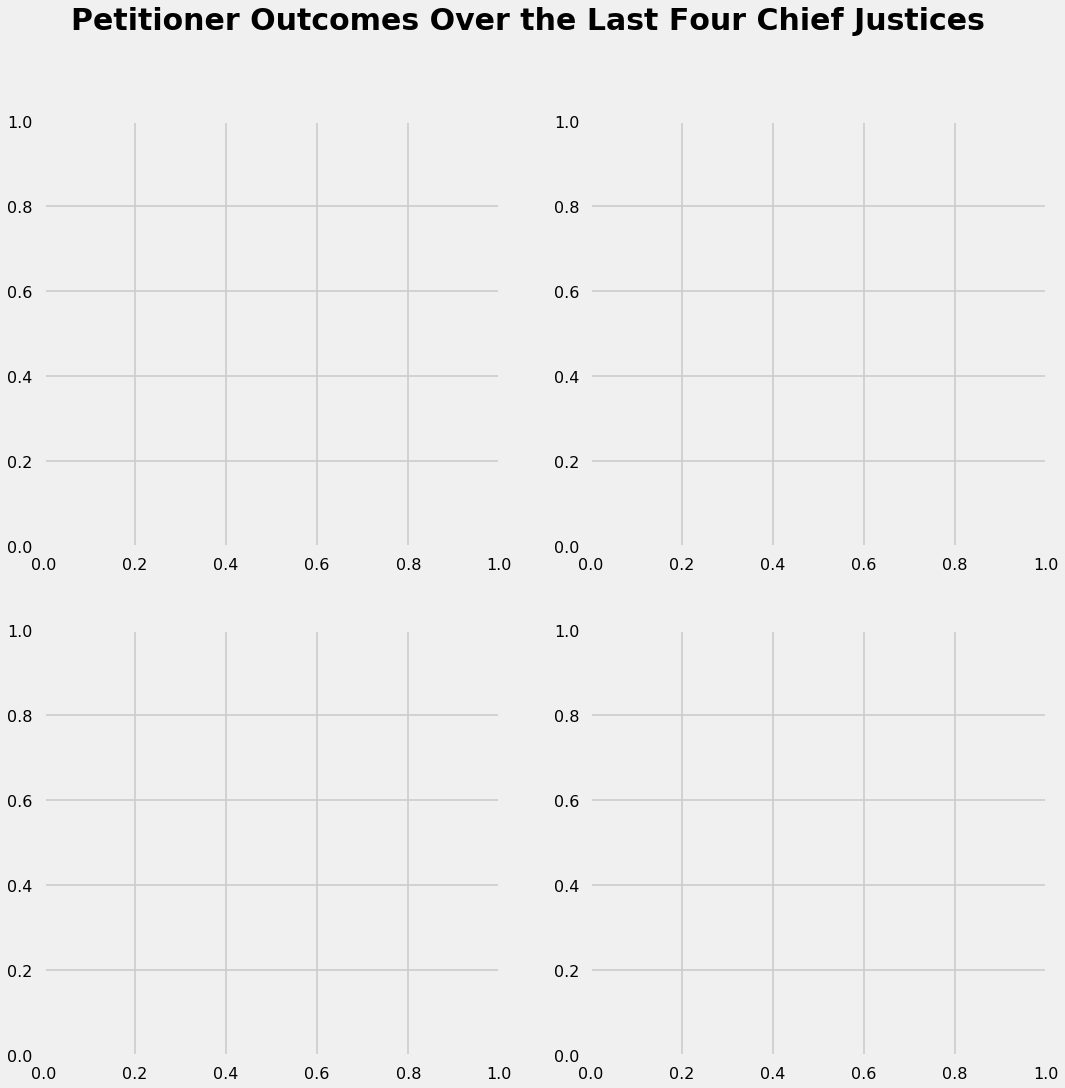

In [126]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 16)) #generating figure and axes
#overall title
labels = ['Favorable for Petitioner', 'Unfavorable for Petitioner']
fig.suptitle("Petitioner Outcomes Over the Last Four Chief Justices", size = 30, fontweight = 'bold')
#graphing each individual plot
axarr[.bar(  labels, Rppw)
axarr[0,0].set_title("Warren (1953 -1969)", size = 20, fontweight = 'bold')
sns.barplot(labels, Bppw, ax = axarr[0,1])
axarr[0,1].set_title("Burger (1969 -  1986)", size = 20, fontweight = 'bold')
sns.barplot(labels, Reppw, ax = axarr[1,0])
axarr[1,0].set_title("Rehnquist (1986 -  2005)", size = 20, fontweight = 'bold')
sns.barplot(labels, Rppw, ax = axarr[1,1])
axarr[1,1].set_title("Roberts (2005 -)", size = 20, fontweight = 'bold')
plt.subplots_adjust( hspace = .2, wspace = .2)

# Text EDA

Now lets do some EDA on our Oral argument

In [51]:
final_df = pd.read_csv("../data/Final_Merge.csv")#reading in the Text data

In [52]:
final_df.text

0       may it please the court this case be here on a...
1       mr chief justice if the court please when the ...
2       mr chief justice and associate justice of the ...
3       may it please the court mr williams this matte...
4       may it please the court mr plauche you may pro...
5       if the court please you might wait just a mome...
6       your honor may it please the court i of course...
7       if the court please virgil herdman the petitio...
8       if the court please mr theard this be a disbar...
9       mr chief justice if the court please this be a...
10      mr chief justice may it please the court this ...
11      thank you sir mr chief justice and may it plea...
12      thank you sir i think that it might be a good ...
13      yes sir may it please the court i represent th...
14      may it please the court I be glad to move now ...
15      may it please the court the court below base i...
16      may it please the court this case result from ...
17      may it

### Most Common Words

First lets take a look at the most common words found in all cases. 

In [53]:
#using a function to tokenize the words and remove stopwords
wordsls = list(map(src.process_article, final_df.text))
#flattening
wordsls = [item for sublist in wordsls for item in sublist]
#using nltk freqdist packages
freq_dis = FreqDist(wordsls)
#into dataframe, unnescary but I was expirementing with some ideas for hues in seaborn
words_df = pd.DataFrame(freq_dis.most_common())

words_df.columns = ('word', 'count')





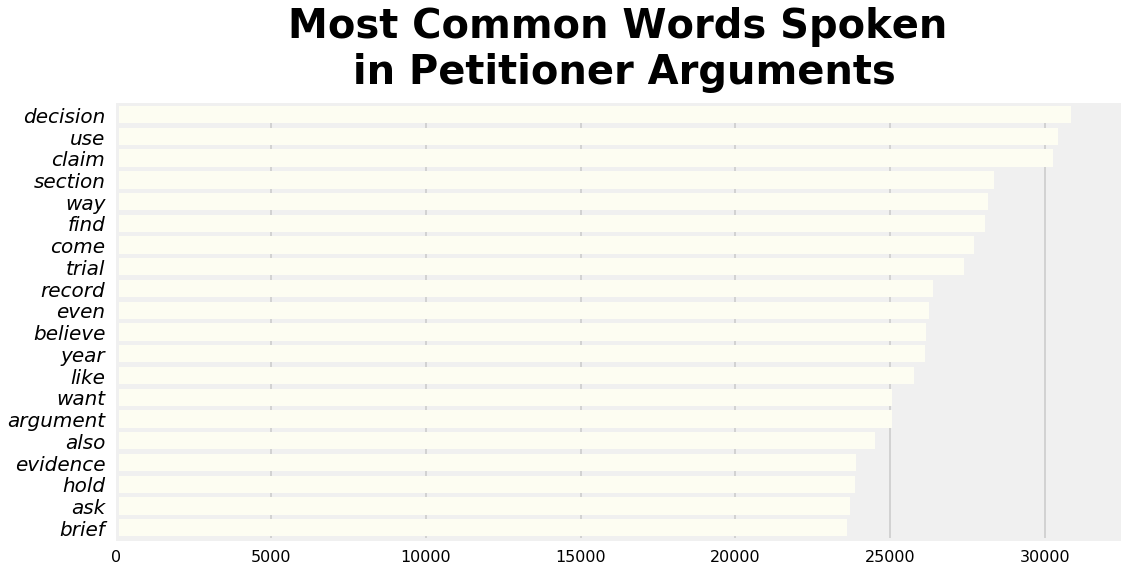

In [54]:
#plotting
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

sns.barplot('count', 'word', data = words_df.head(20), ax = ax, palette = ['ivory'])

ax.set_title('Most Common Words Spoken\n in Petitioner Arguments',  size = 40, fontweight = 'bold',pad = 20, loc= 'center')
# Seaborn automatically makes labels which I got rid of since these graphs are better formatted with just the tick labels in my aesthetic opinion 
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticklabels(labels = words_df.word[0:20], style= 'italic', size = 20)
plt.tight_layout
plt.savefig("../images/most_common.png", bbox_inches='tight')

There are no surprises here, If you had asked me before this project what the most common words used in legal arguments were, it might look alot like this list. I don't know what we are paying lawyers so much for, theres not even any latin!

In [56]:
# making a list so I can use these words as stop words to try to find more insights 
legalstops = list(words_df.word[0:20])
legalstops

['decision',
 'use',
 'claim',
 'section',
 'way',
 'find',
 'come',
 'trial',
 'record',
 'even',
 'believe',
 'year',
 'like',
 'want',
 'argument',
 'also',
 'evidence',
 'hold',
 'ask',
 'brief']

These words were also the most common in both the clasees, so I decided to use them as stopwords since they tell us very little and are uninteresting in general.

### Most Common Words Winning

In [62]:
#same code, the only difference is a different function for removing stop words that incorporates the 20 
#most common words for the dataset overall
winning = final_df[final_df.target == 1]['text']

wordsls2 = list(map(src.process_article2, winning))
                    
wordsls2 = [item for sublist in wordsls2 for item in sublist]

freq_dis2 = FreqDist(wordsls2)

words_df2 = pd.DataFrame(freq_dis2.most_common())

words_df2.columns = ('word', 'count')



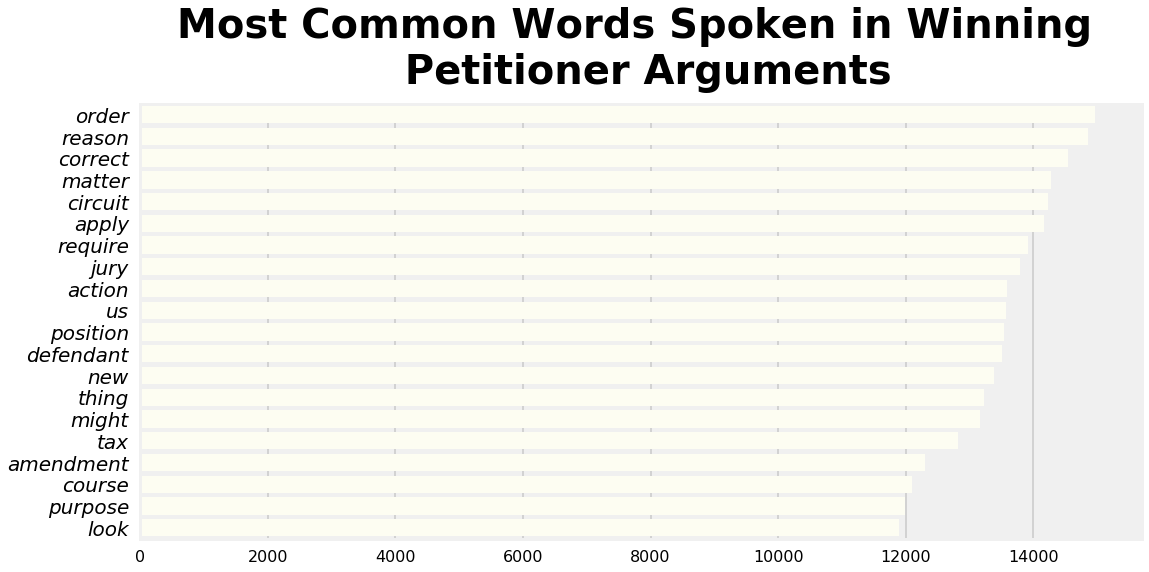

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df2.head(20), ax = ax, palette = ['ivory'])
ax.set_title('Most Common Words Spoken in Winning \n Petitioner Arguments',  size = 40, fontweight = 'bold',pad = 20, loc= 'center')
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(labels = words_df2.word[0:20], style= 'italic', size =20 )
plt.tight_layout
plt.savefig("../images/wordswinning.png", bbox_inches='tight')

More generally boring words and legalese, lets see if theres any differences with losing arguments.

### Most Common Words Losing

In [64]:
losing = final_df[final_df.target == 0]['text']

wordsls3 = list(map(src.process_article2, losing))
                    
wordsls3 = [item for sublist in wordsls3 for item in sublist]

freq_dis3 = FreqDist(wordsls3)

words_df3 = pd.DataFrame(freq_dis3.most_common())

words_df3.columns = ('word', 'count')




In [65]:
#this cell is for creating a custom color pallete that shows the differences between
#the losing and the winning words
top15W = list(words_df2.word[0:20])
top15L = list(words_df3.word[0:20])
colors_dif = []

for x in range(0,20):
    if top15L[x] not in top15W:
        colors_dif.append('tab:red')
    elif top15W[x] == top15L[x]:
        colors_dif.append('ivory')
    else:
         colors_dif.append('tan')


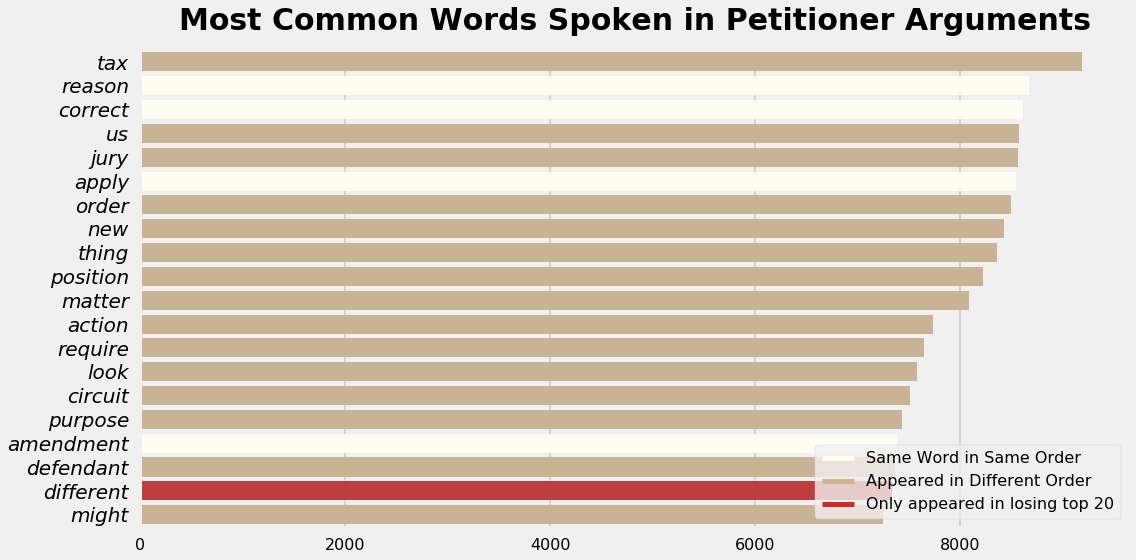

In [151]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df3.head(20), palette = colors_dif, ax = ax)
ax.set_title('Most Common Words Spoken in Petitioner Arguments',  size = 30, fontweight = 'bold', pad = 20, loc= 'center')
ax.set_yticklabels(labels = words_df3.word[0:20], style= 'italic',size = 20 );
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(['Same Word in Same Order', 'Appeared in Different Order', "Only appeared in losing top 20"], loc = "lower right")
leg = ax.get_legend()
leg.legendHandles[0].set_color('ivory')
leg.legendHandles[1].set_color('tan')
leg.legendHandles[2].set_color('tab:red')
plt.tight_layout()
plt.savefig('../images/wordslosing.png')

Apparently the Supreme Court doesnt like New ideas! But seriopuly, thats an alarming amount of similarities between the two classes, I'm starting to think an NLP model will be fairly non viable for classifying between losing and winning arguments.

## Sentiment Analysis

Using the NLTK Vader corpus, I analyzed the sentiment of the response or questions the justices said to the petitioner in each case. Lets see if this is predictive of whether or not the petitioner won  or lost the case. 

### Importing Data

In [43]:
sentdf = pd.read_csv("../data/justice_sentiment.csv")

In [44]:
sentdf.head()

,Unnamed: 0,case,text,target,lib_or_con,majVotes,scores,compound,comp_score
0,0,352us282,that instruction i take it in effect import in...,1,2.0,6,"{'neg': 0.076, 'neu': 0.833, 'pos': 0.091, 'co...",0.9808,1
1,1,353us586,may i at this point ask to be declare inaudibl...,1,2.0,4,"{'neg': 0.072, 'neu': 0.876, 'pos': 0.053, 'co...",-0.9909,2
2,2,352us599,well of course of course you may yes now mr mr...,0,1.0,8,"{'neg': 0.042, 'neu': 0.882, 'pos': 0.075, 'co...",0.9904,1
3,3,352us82,mr williams that do not mean that it be only a...,0,2.0,8,"{'neg': 0.109, 'neu': 0.838, 'pos': 0.054, 'co...",-0.8481,2
4,4,352us220,mr plauche you may proceed deny the united sta...,0,1.0,8,"{'neg': 0.042, 'neu': 0.778, 'pos': 0.179, 'co...",0.9995,1


In [45]:
##Querying the values when the petitioner won, 1= positive, 2 = negative
sentdf[sentdf.target == 1]['comp_score'].value_counts()

1    2712
2    1054
Name: comp_score, dtype: int64

In [46]:
## Querying the values when the petitioner lost, 1= positive, 2= negative
sentdf[sentdf.target == 0]['comp_score'].value_counts()

1    1531
2     629
Name: comp_score, dtype: int64

In [47]:
#putting into lists and making labels
countWs = [1027, 408]
perWs = [x/sum(countWs) for x in countWs]
labelssent = ['Positive Sentiment', 'Negative Sentiment']


countLs = [722, 299]
perLs = [x/sum(countLs) for x in countLs]

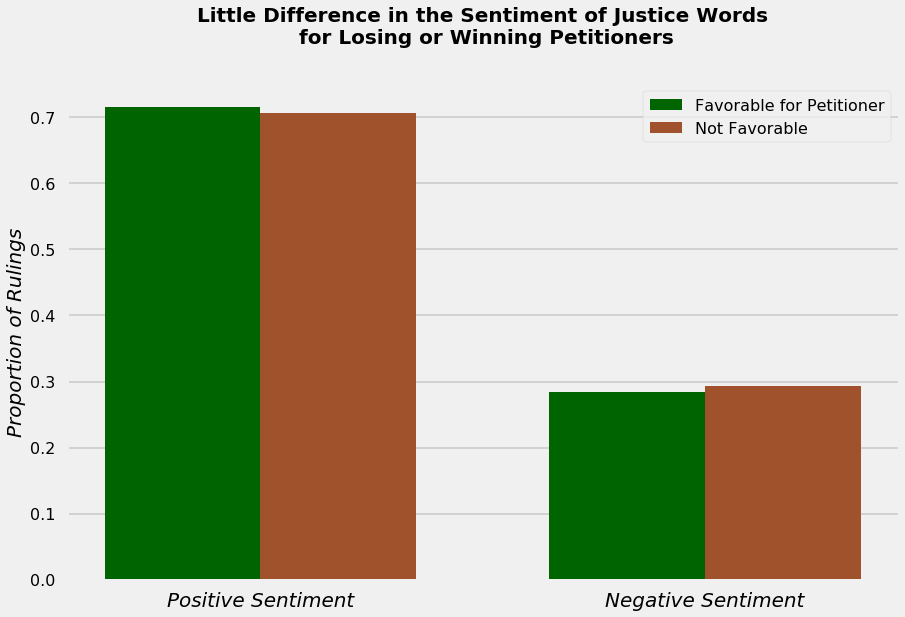

In [152]:
# I basically reused the code from my disposition graph
x = np.arange(len(labelssent))  
width = 0.35  
colorsw = ['darkgreen']
colorsl= ['sienna']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, perWs, width, label='Favorable for Petitioner', color = colorsw)
rects2 = ax.bar(x + width/2, perLs, width, label='Not Favorable', color = colorsl)
ax.set_ylabel('Proportion of Rulings', style = 'italic',size = 20)
ax.set_title('Little Difference in the Sentiment of Justice Words\n for Losing or Winning Petitioners',
             fontweight ='bold', size = 20, pad = 40, loc = 'center')
ax.set_xticks(x)
ax.set_xticklabels(labelssent, style = 'italic', size = 20)
ax.legend()
plt.grid(axis = 'x')
fig.tight_layout()
plt.savefig('../images/sentiment.png', bbox_inches='tight')

# Conclusions

The Classes are extremely similar from an NLP perspective. I filtered out about 40 of the most common words and still found little difference. On the other hand, a lot of the non NLP variables seem promising, particularly the idealogical outcome of the lower court opinion and the issue being argued. I may need to shift my attention away from NLP.